# Fourier Analysis to Find Turbulence in TMC-1 Filament

**By Anna Brandigi**

The HCN data comes from the Undergraduate Project to Map Dense Gas in the Taurus Molecular Cloud, led by Prof. Yancy Shirley. 


In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

## HCN Integrated Intensity Map

### Loading in HCN emission map

This cell loads a 3-D spectral data cube from our map of HCN, which is a FITS file.

First axis = velocity channels

Second/third axes = location in the sky (RA/DEC)

We're looking at HCN (1−0) emission, a tracer of dense gas. Each velocity channel gives us a "slice" through the gas moving at a given velocity along the line of sight.

In [ ]:
filename = 'B10_HCN_map.fits'
hdul = fits.open(filename)
cube_data = hdul[0].data  # shape (303, 256, 179)
hdul.close()

### Investigating Mean Spectrum

Here we're averaging the emission over all spatial pixels to get a 1D velocity spectrum. This tells us the overall shape of HCN emission across our map. It shows where the mass is moving, where there are multiple velocity components, and where there's hyperfine splitting. This is an important step because it allows us to narrow our focus to velocity channels where emission actually occurs. 

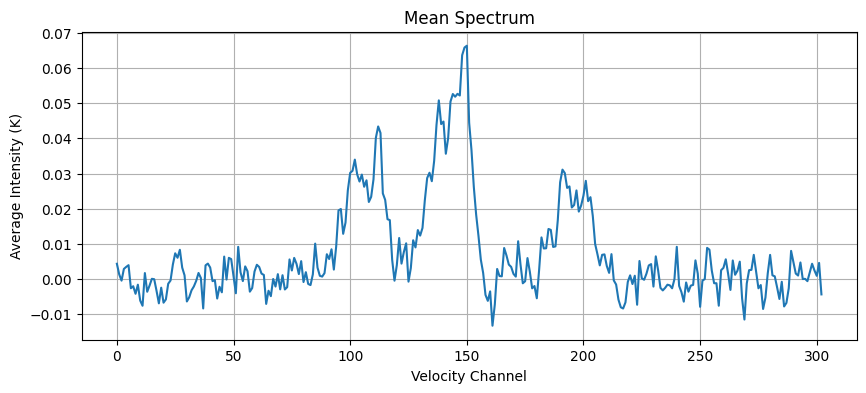

In [15]:
# average intensity and plot by velocity channel
mean_spectrum = np.nanmean(cube_data, axis=(1,2))

# plot spectrum
plt.figure(figsize=(10,4))
plt.plot(mean_spectrum)
plt.xlabel('Velocity Channel')
plt.ylabel('Average Intensity (K)')
plt.title('Mean Spectrum')
plt.grid()
plt.show()


### Integrated Intensity Map

We have a 3-D data cube, and we want to collapse it to 2-D before further analysis. We'll do this by averaging over the velocity channels with np.mean(), which will remove the first axis dimension from the cube, leaving us with just the RA and DEC axes. We will be left with a map of how much HCN emission is coming from each pixel. 

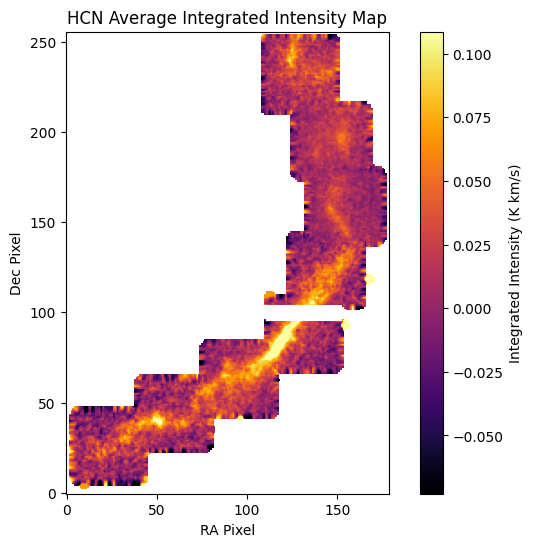

In [16]:
# integrate over channels with emission
velocity_range = cube_data[90:220, :, :]

# sum over velocity axis
average_map = np.mean(velocity_range, axis=0)

plt.figure(figsize=(8,6))
plt.imshow(average_map, origin='lower', cmap='inferno', 
           vmin=np.nanpercentile(average_map,1), 
           vmax=np.nanpercentile(average_map,98.5))
plt.colorbar(label='Integrated Intensity (K km/s)')
plt.title('HCN Average Integrated Intensity Map')
plt.xlabel('RA Pixel')
plt.ylabel('Dec Pixel')
plt.show()

## Fourier Analysis

Now we want to investigate turbulence in a part of the cloud. We'll use Fourier analysis to see how it varies at different scales. 

### Density Gradient Magnitude

We extract the area of the filament that we want to investigate and label it as clump_map. Then we compute the area's density gradient, which tells us how rapidly the intensity (and therefore density of HCN) changes from pixel to pixel. 

Sharp gradients could indicate shock fronts, density discontinuities, or turbulent structures.

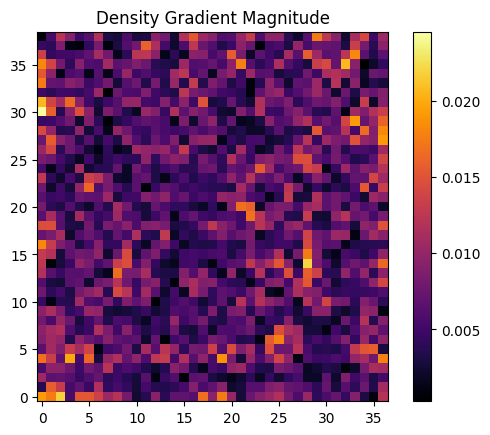

In [17]:
# GREEN REGION

# compute gradients in x and y directions
clump_map = average_map[175:214, 128:165]
grad_x, grad_y = np.gradient(clump_map)

# compute magnitude of gradient
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

# visualize gradient magnitude
plt.imshow(grad_magnitude, cmap='inferno', origin='lower')
plt.title("Density Gradient Magnitude")
plt.colorbar()
plt.show()

### Looking at density gradients of two other regions

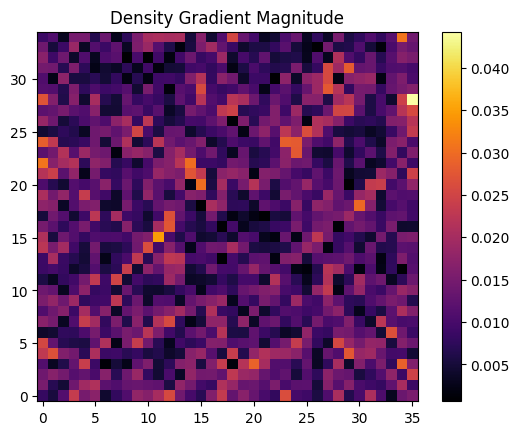

In [18]:
# YELLOW REGION

# compute gradients in x and y directions
yellow_clump_map = average_map[106:141, 125:161]
grad_x, grad_y = np.gradient(yellow_clump_map)

# compute magnitude of gradient
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

# visualize gradient magnitude
plt.imshow(grad_magnitude, cmap='inferno', origin='lower')
plt.title("Density Gradient Magnitude")
plt.colorbar()
plt.show()

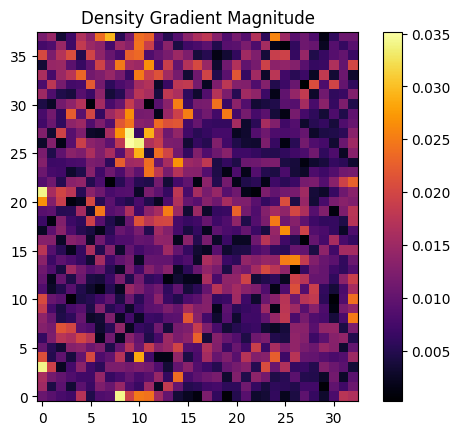

In [19]:
# BLUE REGION

# compute gradients in x and y directions
blue_clump_map = average_map[212:250, 113:146]
grad_x, grad_y = np.gradient(blue_clump_map)

# compute magnitude of gradient
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

# visualize gradient magnitude
plt.imshow(grad_magnitude, cmap='inferno', origin='lower')
plt.title("Density Gradient Magnitude")
plt.colorbar()
plt.show()

### Power Spectrum of Selected Region

Fourier transforms can't handle NaN values (Not a Number -- representing missing on undefined values), so we need to replace them with zeroes. 

The np.fft.fft2() function computes the 2D Fourier transform of the selected clump of the HCN intensity map. This breaks the intensity down according to different spatial frequencies. 

The power spectrum describes how much variance or "power" exists at different spatial frequencies. 

To simplify things, we compute a radially averaged power spectrum, collapsing the 2D power distribution to 1D. It's okay to use a radial average because our selected region is relatively isotropic. 

Spatial frequency (k) is basically the inverse of the physical scale (in pixels) at which intensity variations occur.

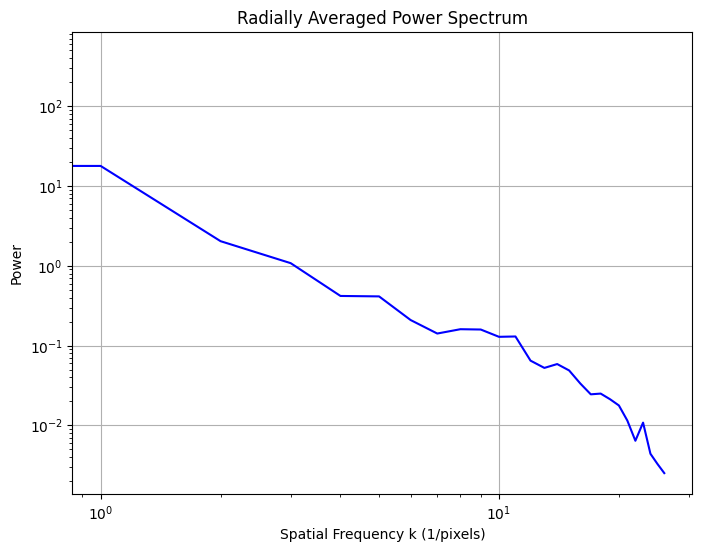

In [24]:
# fill nans with zeros
clump_map = np.nan_to_num(clump_map)

# compute 2D FT of the intensity map
fft2 = np.fft.fft2(clump_map)
# move zero frequency to center
fft2shift = np.fft.fftshift(fft2)  
# power spectrum
power2D = np.abs(fft2shift)**2  

# define radial profile function to average the power spectrum
def radial_profile(data):
    y, x = np.indices(data.shape)  # get coordinates of the data points
    center = np.array([(x.max() + x.min()) / 2.0, (y.max() + y.min()) / 2.0])  # find center
    r = np.hypot(x - center[0], y - center[1])  # compute radial distance from center
    r = r.astype(np.int32)

    # binning
    tbin = np.bincount(r.ravel(), data.ravel())  # sum power values for each radius
    nr = np.bincount(r.ravel())  # points for each radius
    radialprofile = tbin / nr  # normalize by count
    return radialprofile

radial_ps = radial_profile(power2D)

# define k values
kvals = np.arange(len(radial_ps))


plt.figure(figsize=(8, 6))
plt.plot(kvals, radial_ps, label="Power Spectrum", color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency k (1/pixels)')
plt.ylabel('Power')
plt.title('Radially Averaged Power Spectrum')
plt.grid(True)
plt.show()

### Investigating Power Spectrum

Steeper slope (more negative) at high-k means less small-scale power, indicating gas is smoother at small scales.

Shallower slope at low-k means more energy in large-scale motions and could be a signature of cloud-scale turbulence or gravitational collapse.

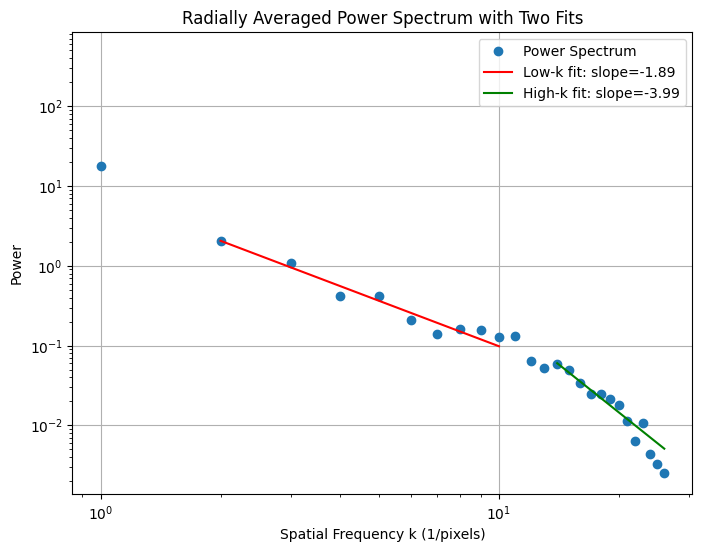

In [21]:
def power_law(k, A, slope):
    return A * k**slope

k_break = 11  # break point btwn low-k and high-k

# low-k region
lowk_mask = (kvals > 1) & (kvals < k_break)
popt_low, pcov_low = curve_fit(power_law, 
        kvals[lowk_mask], radial_ps[lowk_mask], p0=[1e-2, -2])

# high-k region
highk_mask = (kvals > k_break + 2) & (kvals < 150)
popt_high, pcov_high = curve_fit(power_law, 
        kvals[highk_mask], radial_ps[highk_mask], p0=[1e-5, -3])

# plot PS with fitted curves
plt.figure(figsize=(8,6))
plt.plot(kvals, radial_ps, marker='o', linestyle='', label="Power Spectrum")
plt.plot(kvals[lowk_mask], power_law(kvals[lowk_mask], *popt_low), label=f'Low-k fit: slope={popt_low[1]:.2f}', color='red')
plt.plot(kvals[highk_mask], power_law(kvals[highk_mask], *popt_high), label=f'High-k fit: slope={popt_high[1]:.2f}', color='green')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency k (1/pixels)')
plt.ylabel('Power')
plt.title('Radially Averaged Power Spectrum with Two Fits')
plt.legend()
plt.grid(True)
plt.show()
